https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew
    
https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p


With the surge in popularity of ridesharing apps such as Uber and Lyft over traditional taxi services, consumers trade convienince for a general lack of tranparency regarding prices. Ridesharing services often seem like a better deal than taxi services, but prices fluctuate drastically depending on demand and service choice. Companies such as Bellhop seek to make it easy for users to compare services, and can help users make choices between ridesharing and taxis in real time. I want to find a quantitive answer to the question of weather a given ridesharing price is fair given averages across services and taxi service. More specifically, given ride endpoints and estimated ride time, can we predict what the ridesharing price should be?

My proposal centers around two datasets: the recently released 'Transportation Network Providers' (TNP) data and 'Taxi-Trips' data from the city of Chicago government website. Analysis will focus on the most recent data (2018 in for the TNP and 2017 for the taxi trips). A project plan is listed below. Items 1-2 have been completed for preliminary analysis, while items 2-_ would be part of a full project.

1. Exploratory analysis of TNP dataset
    - What is the distribution of prices, how directly do they correlate with trip time and location?
    - What data features actually matter for price? 
    - Are there price/usage trends?
2. Exploratory analysis of Taxi dataset
    - Same as above, these are very similar looking datasets
3. Are there any general trends to note between the two datasets... eg.. Taxi is almost always better?
4. Create predictive models for the price for each of the above. Test/train split before going any further. (using some ML eg.. random forest)
5. Provide a web interface where a user can give their route information in chicago. We tell them an estimated taxi/TNP price and they can compare their offers with that. 


One issue: the taxi dataset ends in 2017. For now, we will compare prices over two months from both datasets. That is Jun and July 2017 in the taxi data and Nov. and Dec 2018 for the TNP dataset. At some point we can also see if the choice of the time window (in eg... winter) for the taxi dataset affects the model strongly.

   

In [120]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import random
from sklearn.base import BaseEstimator, TransformerMixin


# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


Let's start by analysing the TNP dataset. For this preliminary analysis, we'll use only a random sampling of the dataset.

In [6]:
p = 0.15 # Percentage of dataset to keep

tnp = pd.read_csv(
         'Transportation_Network_Providers_-_Trips.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)


In [7]:
tnp.columns = tnp.columns.str.replace(' ', '_') # for dot notation

Dropping a lot of extra categorical and other variables for now, may add them later and see if they can help fit performance.

In [8]:
currently_unused_col = ['Trip_ID','Trip_End_Timestamp','Pickup_Census_Tract', 'Dropoff_Census_Tract','Pickup_Community_Area', 
                        'Dropoff_Community_Area','Tip','Additional_Charges', 'Trip_Total', 'Shared_Trip_Authorized','Trips_Pooled']
tnp.drop(currently_unused_col, axis=1, inplace=True)

In [9]:
tnp['Trip_Start_Timestamp'] = pd.to_datetime(tnp['Trip_Start_Timestamp'],infer_datetime_format = True)

In [10]:
tnp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615856 entries, 0 to 2615855
Data columns (total 10 columns):
Trip_Start_Timestamp          datetime64[ns]
Trip_Seconds                  float64
Trip_Miles                    float64
Fare                          float64
Pickup_Centroid_Latitude      float64
Pickup_Centroid_Longitude     float64
Pickup_Centroid_Location      object
Dropoff_Centroid_Latitude     float64
Dropoff_Centroid_Longitude    float64
Dropoff_Centroid_Location     object
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 199.6+ MB


Generally a user only cares about the price given a distance and time, 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabeb590780>,
      dtype=object)

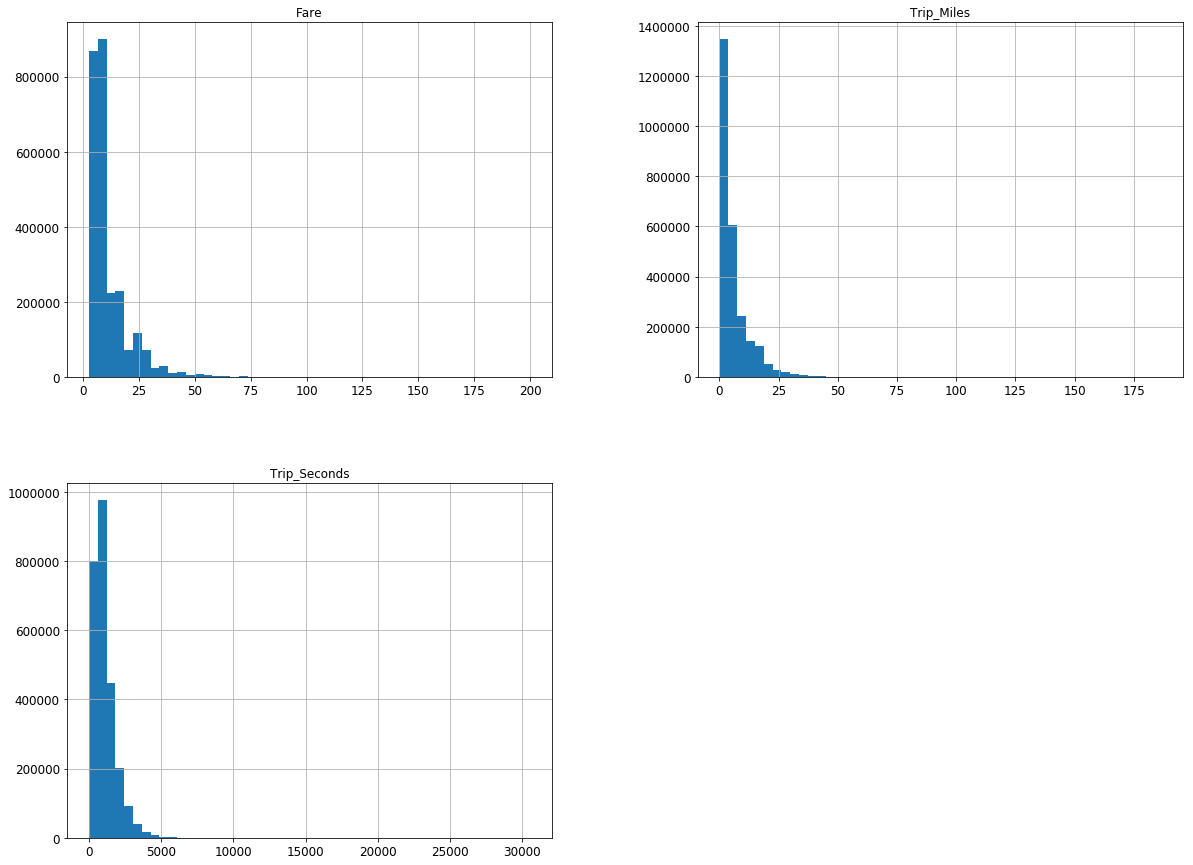

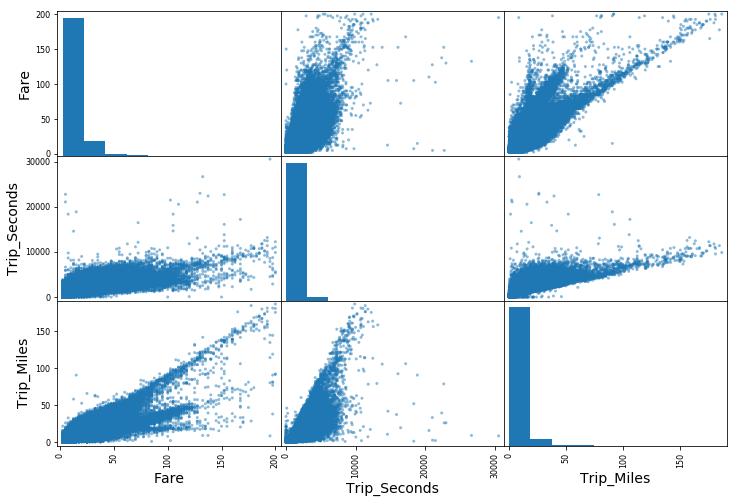

In [164]:
key_attributes = ['Fare','Trip_Seconds','Trip_Miles']
tnp[key_attributes].hist(bins = 50, figsize = (20,15))

In [ ]:
scatter_matrix(tnp[attributes],figsize = (12,8))

The fare is, as expected, heavily correlated with the duration and the length of the ride. To perform better for larger fares, we'll use stratified sampling on the trip_miles.

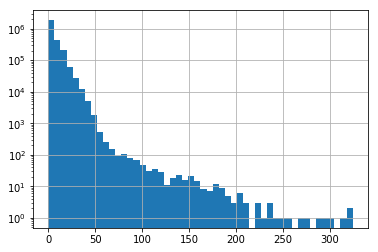

In [12]:
tnp.Trip_Miles.hist(bins = 50, log = True)
# Drop trips with no distance attribute
tnp.drop(tnp[tnp.Trip_Miles <=0].index, inplace=True)

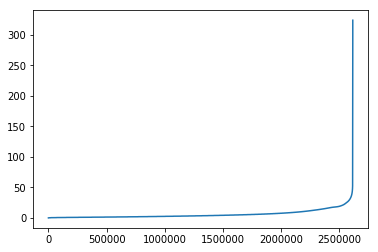

In [13]:
# bin the trip length
plt.plot(tnp.Trip_Miles.sort_values().values)

In [14]:
# drop unusually large or small fares
tnp.drop(tnp[((tnp.Fare > 200) | (tnp.Fare <= 0))].index,inplace = True)

In [15]:
cat_size = 3.
max_bin_dist = 30
tnp["distance_cat"]= np.ceil(tnp["Trip_Miles"]/cat_size) 

# lump all rides above 30 nules into category 
tnp["distance_cat"].where(tnp["distance_cat"]<max_bin_dist/cat_size,max_bin_dist/cat_size,inplace=True)

In [16]:
tnp["distance_cat"].value_counts()

1.0     1115883
2.0      657733
3.0      298691
4.0      154157
5.0      110401
6.0       99088
7.0       62396
10.0      41590
8.0       26298
9.0       19704
Name: distance_cat, dtype: int64

In [17]:
tnp.count()

Trip_Start_Timestamp          2585941
Trip_Seconds                  2585579
Trip_Miles                    2585941
Fare                          2585923
Pickup_Centroid_Latitude      2433528
Pickup_Centroid_Longitude     2433528
Pickup_Centroid_Location      2433528
Dropoff_Centroid_Latitude     2413761
Dropoff_Centroid_Longitude    2413761
Dropoff_Centroid_Location     2413761
distance_cat                  2585941
dtype: int64

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state = 1337)
for train_index, test_index in split.split(tnp,tnp["distance_cat"]):
    strat_train_set = tnp.iloc[train_index]
    strat_test_set = tnp.iloc[test_index]

In [19]:
strat_test_set.count()

Trip_Start_Timestamp          517189
Trip_Seconds                  517114
Trip_Miles                    517189
Fare                          517187
Pickup_Centroid_Latitude      486868
Pickup_Centroid_Longitude     486868
Pickup_Centroid_Location      486868
Dropoff_Centroid_Latitude     482508
Dropoff_Centroid_Longitude    482508
Dropoff_Centroid_Location     482508
distance_cat                  517189
dtype: int64

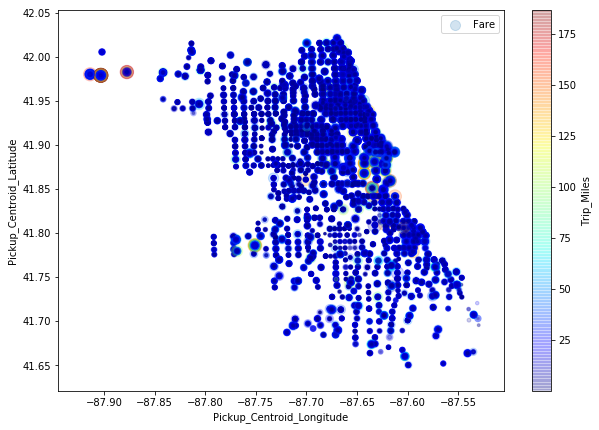

In [20]:
strat_train_set.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()

In [21]:
strat_train_set.columns

Index(['Trip_Start_Timestamp', 'Trip_Seconds', 'Trip_Miles', 'Fare',
       'Pickup_Centroid_Latitude', 'Pickup_Centroid_Longitude',
       'Pickup_Centroid_Location', 'Dropoff_Centroid_Latitude',
       'Dropoff_Centroid_Longitude', 'Dropoff_Centroid_Location',
       'distance_cat'],
      dtype='object')

### Model Fitting
Going to drop N/A columns for this first pass.

In [22]:
strat_train_set.dropna(inplace = True)
fare_labels = strat_train_set["Fare"].copy()
ride_features = strat_train_set.drop("Fare", axis = 1)
ride_features[ride_features.isnull().any(axis=1)].head() # Incomplete rows
# specialize to the hour for timestaps:
ride_features['Trip_Start_Timestamp'] = ride_features.Trip_Start_Timestamp.dt.hour
ride_features.drop(["Pickup_Centroid_Location","Dropoff_Centroid_Location"], axis = 1, inplace = True)

/home/isaac/anaconda3/envs/skstack/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
print(ride_features.count(),fare_labels.count())

Trip_Start_Timestamp          1809724
Trip_Seconds                  1809724
Trip_Miles                    1809724
Pickup_Centroid_Latitude      1809724
Pickup_Centroid_Longitude     1809724
Dropoff_Centroid_Latitude     1809724
Dropoff_Centroid_Longitude    1809724
distance_cat                  1809724
dtype: int64 1809724


In [149]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(ride_features[['Trip_Seconds','Trip_Miles']],fare_labels)

# quick test
some_data = ride_features.iloc[:10]
some_labels = fare_labels.iloc[:10]
print("Predictions: ",lin_reg.predict(some_data[['Trip_Seconds','Trip_Miles']]))
print("Labels: ",list(some_labels))

# Linear underfitting
from sklearn.metrics import mean_squared_error
fare_predictions = lin_reg.predict(ride_features[['Trip_Seconds','Trip_Miles']])
lin_mse = mean_squared_error(fare_labels, fare_predictions)
print("RMSE: ", np.sqrt(lin_mse))

Predictions:  [ 9.57243691  4.76155886 12.34052958 14.08150092  5.26820025  8.55943717
  7.9455026   8.26306871  6.51648568  6.67385352]
Labels:  [10.0, 5.0, 15.0, 12.5, 5.0, 10.0, 10.0, 7.5, 7.5, 5.0]
RMSE:  3.689000591439577


In [151]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, ride_features[['Trip_Seconds','Trip_Miles']], fare_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3.67100814 3.67404886 3.69641782 3.66936841 3.71000759 3.6944731
 3.68372174 3.64368117 3.67008741 3.77589644]
Mean: 3.6888710678801457
Standard deviation: 0.033836530603961745


### Taxi dataset

In [152]:
p = 1  # taxi usage is significantly smaller
taxi = pd.read_csv(
         'Taxi_Trips_Dec.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

In [153]:
taxi.count()

Trip ID                       2510635
Taxi ID                       2509483
Trip Start Timestamp          2510635
Trip End Timestamp            2510403
Trip Seconds                  2510100
Trip Miles                    2510600
Pickup Census Tract           1606891
Dropoff Census Tract          1597621
Pickup Community Area         2280976
Dropoff Community Area        2234209
Fare                          2510595
Tips                          2510595
Tolls                         2510595
Extras                        2510595
Trip Total                    2510595
Payment Type                  2510635
Company                       1381763
Pickup Centroid Latitude      2281063
Pickup Centroid Longitude     2281063
Pickup Centroid Location      2281063
Dropoff Centroid Latitude     2239201
Dropoff Centroid Longitude    2239201
Dropoff Centroid  Location    2239201
dtype: int64

In [154]:
taxi.columns = taxi.columns.str.replace(' ', '_') # for dot notation

currently_unused_col = ['Trip_ID','Taxi_ID','Trip_End_Timestamp','Pickup_Census_Tract', 'Dropoff_Census_Tract','Pickup_Community_Area', 
                        'Dropoff_Community_Area','Tips','Tolls','Extras','Trip_Total','Payment_Type','Company',
                       'Pickup_Centroid_Location', 'Dropoff_Centroid__Location']

taxi.drop(currently_unused_col, axis=1, inplace=True)

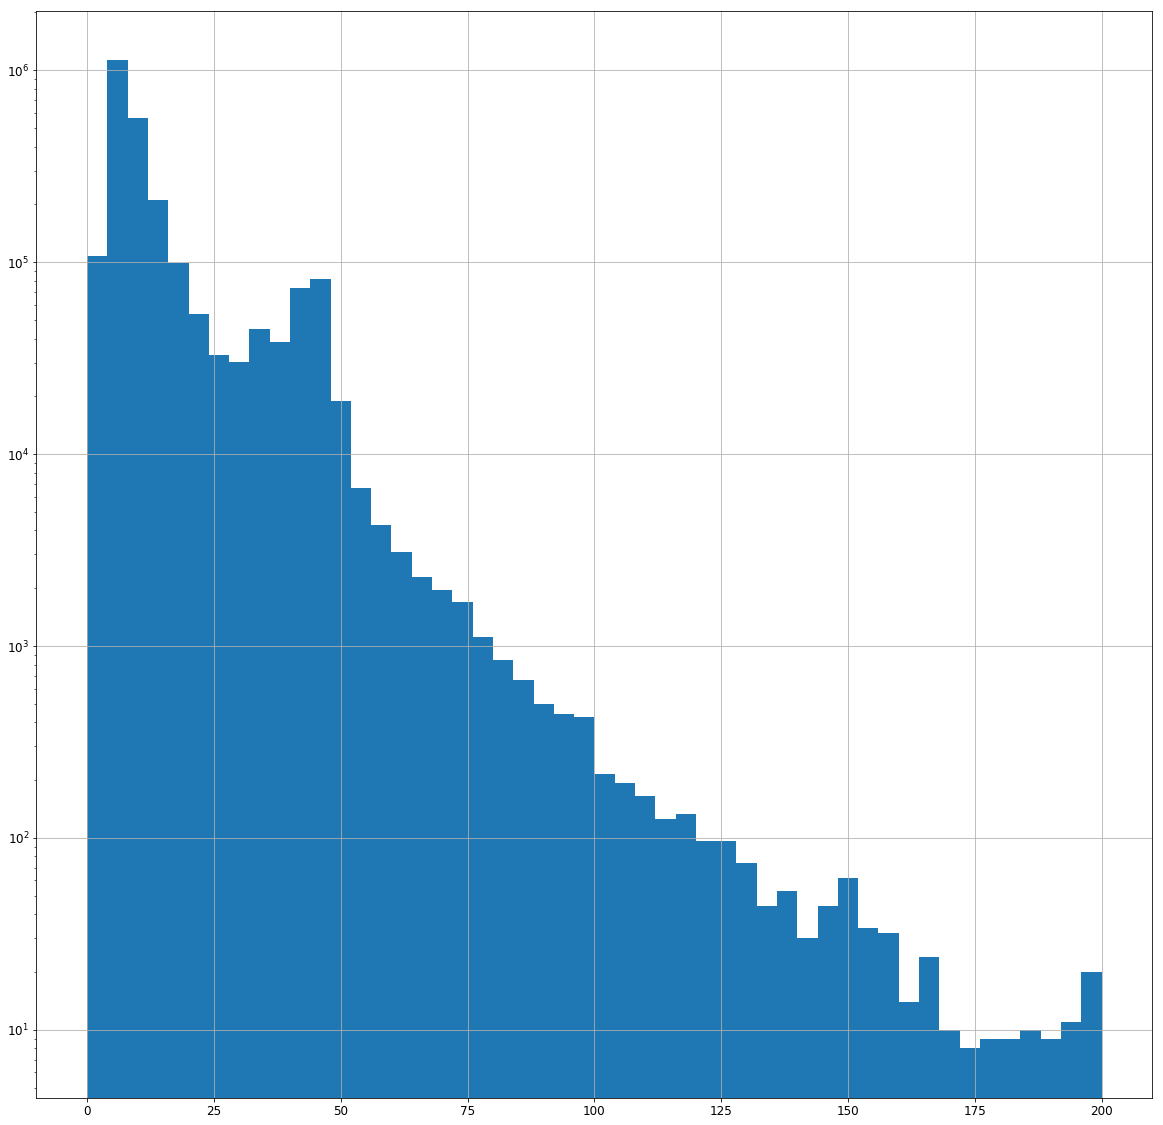

In [155]:
# there are some exceedingly large fares, lets drop them along with zero fees
taxi.drop(taxi[((taxi.Fare > 200) | (taxi.Fare <= 0))].index,axis = 0, inplace = True)
taxi.head()
taxi.Fare.hist(bins = 50, figsize = (20,20),log = True)

In [156]:
taxi.dtypes
taxi['Trip_Start_Timestamp'] = pd.to_datetime(taxi['Trip_Start_Timestamp'],infer_datetime_format = True)

In [157]:
cat_size = 3.
max_bin_dist = 30
taxi["distance_cat"]= np.ceil(taxi["Trip_Miles"]/cat_size) 

# lump all rides above 30 miles into category 
taxi["distance_cat"].where(taxi["distance_cat"]<max_bin_dist/cat_size,max_bin_dist/cat_size,inplace=True)

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state = 17)
for train_index, test_index in split.split(taxi,taxi["distance_cat"]):
    strat_train_set = taxi.iloc[train_index]
    strat_test_set = taxi.iloc[test_index]

In [158]:
strat_train_set.dropna(inplace = True)
fare_labels_t = strat_train_set["Fare"].copy()
ride_features_t = strat_train_set.drop("Fare", axis = 1)
ride_features_t[ride_features_t.isnull().any(axis=1)].head() # Incomplete rows
ride_features_t.dropna(inplace = True)
# specialize to the hour for timestaps:
ride_features_t['Trip_Start_Timestamp'] = ride_features_t.Trip_Start_Timestamp.dt.hour


/home/isaac/anaconda3/envs/skstack/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [159]:
print(ride_features_t.count(),fare_labels_t.count())

Trip_Start_Timestamp          1779953
Trip_Seconds                  1779953
Trip_Miles                    1779953
Pickup_Centroid_Latitude      1779953
Pickup_Centroid_Longitude     1779953
Dropoff_Centroid_Latitude     1779953
Dropoff_Centroid_Longitude    1779953
distance_cat                  1779953
dtype: int64 1779953


In [163]:
lin_reg_t = LinearRegression()
lin_reg_t.fit(ride_features_t,fare_labels_t)

# quick test
some_data = ride_features.iloc[:10]
some_labels = fare_labels.iloc[:10]
print("Predictions: ",lin_reg.predict(some_data))
print("Labels: ",list(some_labels))

# Linear underfitting
fare_predictions_t = lin_reg_t.predict(ride_features_t)
lin_mse = mean_squared_error(fare_labels_t, fare_predictions_t)
print("RMSE: ", np.sqrt(lin_mse))

ValueError: shapes (10,8) and (2,) not aligned: 8 (dim 1) != 2 (dim 0)

In [ ]:
taxi_estimate_on_ridesare = lin_reg_t.predict(ride_features)
rideshare_estimate_on_taxi = lin_reg.predict(ride_features_t)

In [ ]:
plt.plot(taxi_estimate_on_ridesare)
plt.plot(rideshare_estimate_on_taxi)

In [ ]:
taxi.Fare.hist(bins = 50, log = True)
tnp.Fare.hist(bins = 50)
tnp.Fare.max()

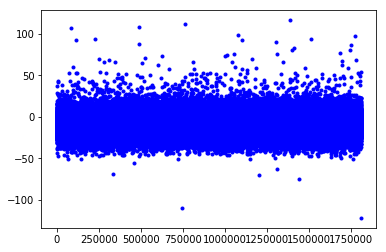

In [59]:
plt.plot(fare_labels.values-taxi_estimate_on_ridesare, 'b.')
#plt.plot(taxi_estimate_on_ridesare)

6.869922935290523 5.1954946528839345


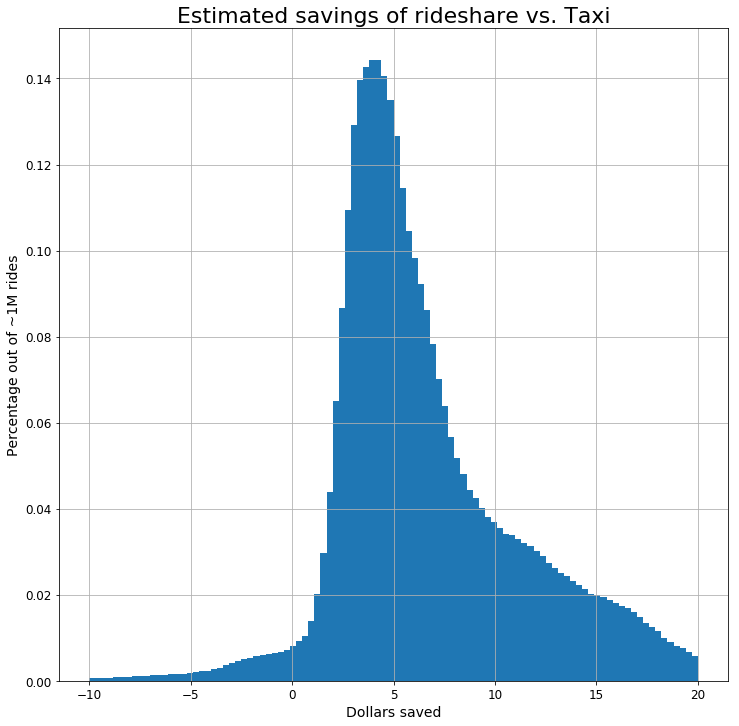

In [161]:
tnp_savings = (taxi_estimate_on_ridesare-fare_labels)
tnp_savings.hist(bins = 100,figsize = (12,12),range=[-10,20], density = True)
plt.title("Estimated savings of rideshare vs. Taxi", fontsize = 22)
plt.ylabel("Percentage out of ~1M rides")
plt.xlabel("Dollars saved")
print(tnp_savings.mean(),tnp_savings.std())

In [162]:
((fare_labels_t-rideshare_estimate_on_taxi)).hist(bins = 50, figsize = (20,20),range=[-5,30])

ValueError: operands could not be broadcast together with shapes (1779953,) (1454720,) 

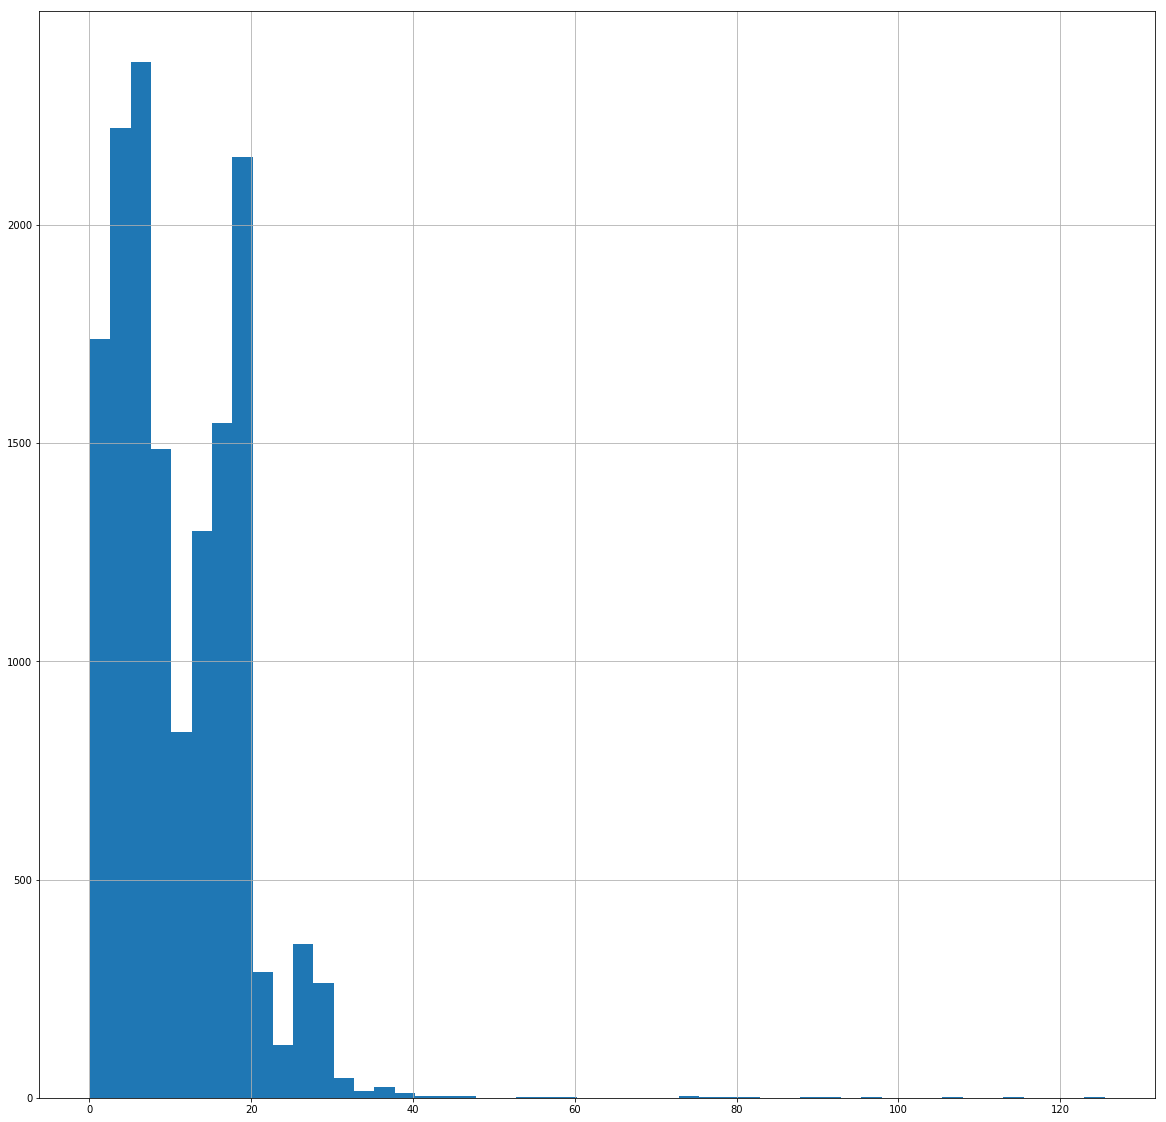

In [62]:
ride_features[(fare_labels-taxi_estimate_on_ridesare) >5].Trip_Miles.hist(bins = 50, figsize = (20,20))

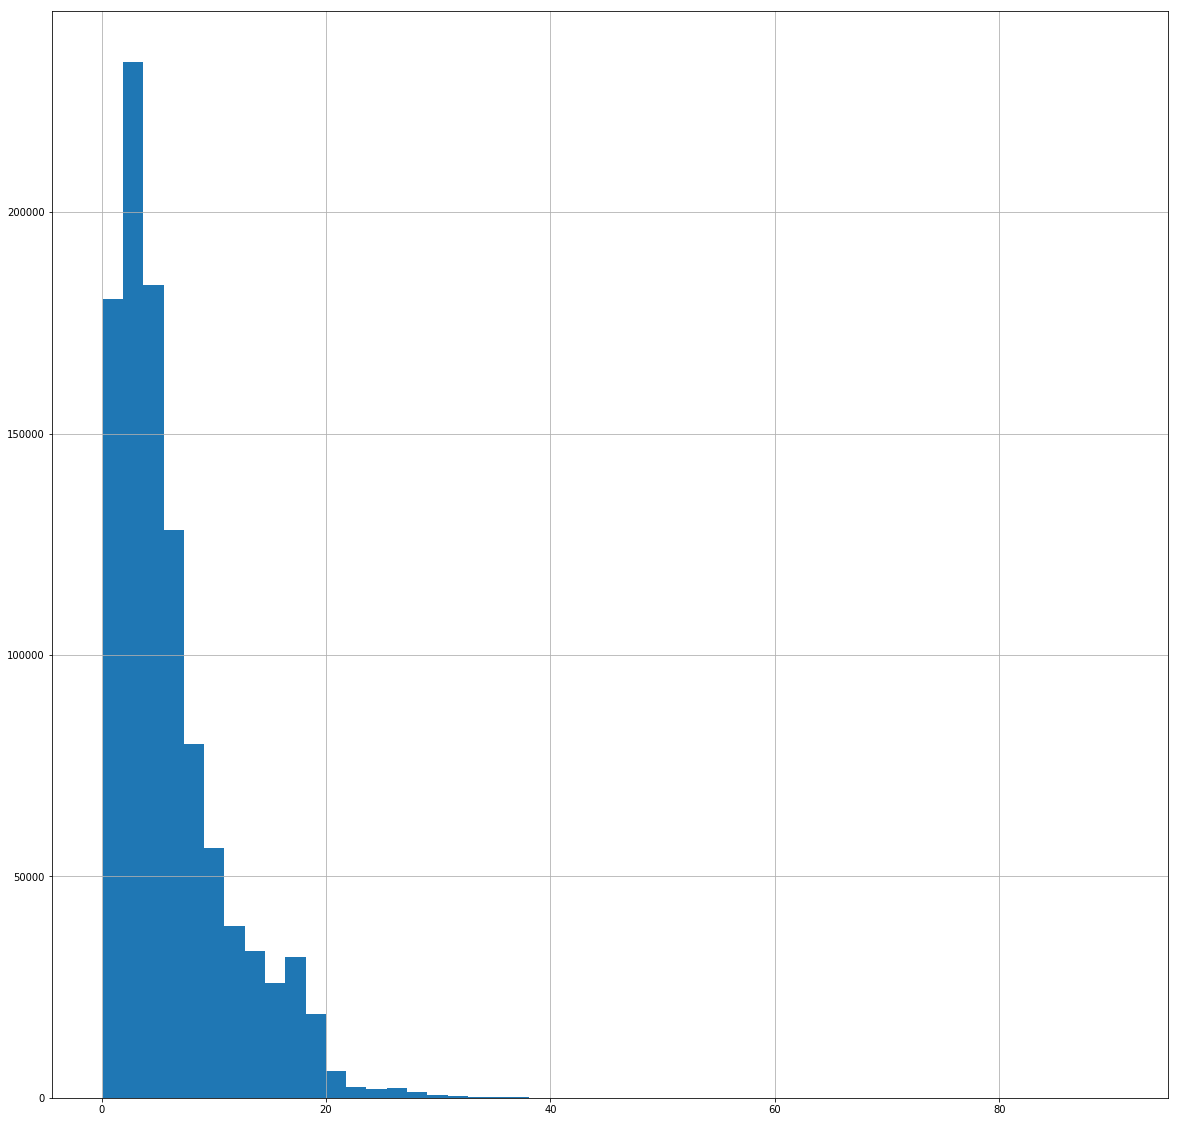

In [85]:
ride_features[(fare_labels-taxi_estimate_on_ridesare) <-5].Trip_Miles.hist(bins = 50, figsize = (20,20))

In [86]:
good_taxi_rides = ride_features[(fare_labels-taxi_estimate_on_ridesare) >5]
good_tnp_rides = ride_features[(fare_labels-taxi_estimate_on_ridesare) <-5]

In [ ]:
good_tnp_rides.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()

In [ ]:
good_taxi_rides.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()

In [88]:
play = ride_features.copy()

In [90]:
play["cost_diff"] = np.ceil(10*(fare_labels-taxi_estimate_on_ridesare)/100)

In [103]:
play.groupby("cost_diff").Trip_Seconds.mean()

cost_diff
-12.0    18874.000000
-10.0    22744.000000
-7.0     14259.500000
-6.0     13508.000000
-5.0      4862.500000
-4.0      3829.415385
-3.0      3067.015643
-2.0      2358.765064
-1.0      1512.746011
-0.0       783.898884
 1.0      1012.484486
 2.0      2335.546214
 3.0      2647.765517
 4.0      2267.175182
 5.0      2545.543210
 6.0      2712.972222
 7.0      2609.583333
 8.0      6663.375000
 9.0      3260.400000
 10.0     4048.142857
 11.0     3426.500000
 12.0      931.000000
Name: Trip_Seconds, dtype: float64

In [ ]:
play.cost_diff.value_counts()

In [ ]:
play[(np.abs(play["cost_diff"])>3)]

### Measurering ride 'fairness' as deviation from the mean given distance, location and time.

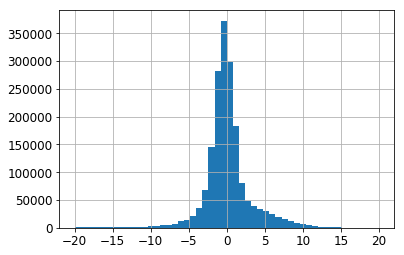

In [133]:
(fare_predictions - fare_labels).hist(bins = 50, range = [-20,20])

In [138]:
ride_features[(fare_predictions - fare_labels)<-10].iloc[:10]

,Trip_Start_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,distance_cat
2126256,3,1356.0,6.5,41.880994,-87.632746,41.946295,-87.654298,3.0
1562187,16,1590.0,7.4,41.892508,-87.626215,41.832937,-87.653583,3.0
1958199,16,1162.0,6.1,41.914616,-87.631717,41.928619,-87.685362,3.0
2038055,0,2848.0,7.2,41.805912,-87.587479,41.805912,-87.587479,3.0
562930,3,2002.0,10.8,42.001698,-87.673574,41.870607,-87.622173,4.0
981660,16,4108.0,14.6,41.979071,-87.903040,41.920452,-87.679955,5.0
451020,18,3361.0,14.7,41.892508,-87.626215,42.005608,-87.813098,5.0
2023952,18,1687.0,7.5,41.885300,-87.642808,41.950673,-87.666536,3.0
1873992,3,905.0,7.1,41.958155,-87.653022,41.870607,-87.622173,3.0
548687,21,1292.0,12.2,41.785999,-87.750934,41.890922,-87.618868,5.0


In [139]:
fare_labels[(fare_predictions - fare_labels)<-10].iloc[:10]

2126256    22.5
1562187    25.0
1958199    22.5
2038055    52.5
562930     35.0
981660     57.5
451020     52.5
2023952    27.5
1873992    22.5
548687     37.5
Name: Fare, dtype: float64

In [140]:
ride_features[(fare_predictions - fare_labels)>10].iloc[:10]

,Trip_Start_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,distance_cat
910025,19,2955.0,13.1,41.789661,-87.718220,41.929047,-87.651311,5.0
445532,23,1909.0,12.6,41.993441,-87.657418,41.915741,-87.692256,5.0
1581759,0,2698.0,7.1,41.859350,-87.617358,41.945170,-87.668794,3.0
2569032,17,2654.0,6.4,41.899602,-87.633308,41.878914,-87.705897,3.0
2232038,23,2925.0,6.4,41.936310,-87.651563,41.879255,-87.642649,3.0
2026059,11,1123.0,8.0,41.994442,-87.665225,41.899156,-87.626211,3.0
2528628,18,4452.0,41.2,41.980264,-87.913625,41.740206,-87.615970,10.0
718859,10,2385.0,11.2,42.001571,-87.695013,41.878866,-87.625192,4.0
2595726,5,1297.0,9.5,42.001571,-87.695013,41.878866,-87.625192,4.0
2612527,22,2071.0,14.4,41.817366,-87.698861,41.927261,-87.765502,5.0


In [141]:
fare_labels[(fare_predictions - fare_labels)>10].iloc[:10]

910025     10.0
445532      7.5
1581759     5.0
2569032     5.0
2232038     5.0
2026059     2.5
2528628    27.5
718859      7.5
2595726     5.0
2612527    10.0
Name: Fare, dtype: float64

In [143]:
lin_reg.coef_

array([ 2.78739955e-03,  2.10388200e-03,  1.02739232e+00,  4.03480657e+00,
       -1.00930279e+00,  2.20708957e-01, -6.46766036e+00, -4.91254995e-02])

In [146]:
ride_features

,Trip_Start_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,distance_cat
1617549,22,1197.0,4.3,41.899507,-87.679600,41.855990,-87.664907,2.0
63357,21,450.0,1.2,41.934762,-87.639854,41.942585,-87.656644,1.0
2463348,0,1868.0,5.6,41.968069,-87.721559,41.944227,-87.655998,2.0
372069,14,2598.0,5.8,41.958056,-87.660389,41.899156,-87.626211,2.0
1530793,21,492.0,1.6,41.885300,-87.642808,41.891972,-87.612945,1.0
2604788,12,1163.0,3.4,41.944227,-87.655998,41.922761,-87.699155,2.0
2180859,23,1020.0,3.1,41.928619,-87.685362,41.938232,-87.646782,2.0
1272459,0,1670.0,2.1,41.877406,-87.621972,41.900221,-87.629105,1.0
291674,18,688.0,2.4,41.885281,-87.657233,41.900266,-87.632109,1.0
1268739,3,763.0,2.4,41.890922,-87.618868,41.890922,-87.618868,1.0


### API related stuff (currently unused for initial analysis):

In [ ]:
query = ("https://data.cityofchicago.org/resource/m6dm-c72p.json")
raw_data = pd.read_json(query)

uname = 'bobmeetsabe@gmail.com'
APPTOK = 'leL1qsHufdxYHXCdRVR3FtdgN'

client = Socrata("data.cityofchicago.org",
                  APPTOK,
                  username=uname,
                  password="SsthSrZ65XFMW3e")

#results = client.get("m6dm-c72p", limit=int(1e6), order="trip_start_timestamp DESC")
#tnp = pd.DataFrame.from_records(results)